In [1]:
# 가로로 넓게 쓰기
from IPython.core.display import display, HTML  
display(HTML(""))

print("Setup Complete")

Setup Complete


In [2]:
import pandas as pd
import numpy as np
import os

import time 
import datetime as dt
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import LabelEncoder

In [3]:
# def make_df(df, label):
    
#     for col in label:
#         print(col)
#         le = LabelEncoder()
#         k = df.pop(col)
#         le.fit(k)
#         k = pd.DataFrame(le.transform(k))
#         df = pd.concat([df, k], axis=1)
        
#     return df

In [4]:
def generate_features(df):
    df['STD_DT'] = df['STD_DT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    df.loc[:, 'weekofyear'] = df['STD_DT'].dt.weekofyear
    df.loc[:, 'dayofweek'] = df['STD_DT'].dt.dayofweek
    df.loc[:, 'weekend'] = (df['STD_DT'].dt.weekday >=5).astype(int)
#     df.loc[:, 'hour'] = df['STD_DT'].dt.hour
#     df.loc[:, 'min'] = df['STD_DT'].dt.mimute
    
    return df

In [5]:
path = "/home/kym/ML/input/kamp/대회 과제"
os.chdir(path)

df = pd.read_csv('melting_tank_mod.csv', encoding='cp949')

df = generate_features(df)
feature = [
    f for f in df.columns if f in ("STD_DT", "MELT_TEMP", "MOTORSPEED", "MELT_WEIGHT", "weekofyear", "dayofweek", "weekend", "TAG")
]

df = df[feature]
# df = make_df(df, ['TAG'])
# df.drop([0], axis=1, inplace=True)
df.to_csv('/home/kym/ML/input/kamp/대회 과제/melting_tank_final.csv', index=False)
df.head()

/tmp/ipykernel_9832/1836040535.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df.loc[:, 'weekofyear'] = df['STD_DT'].dt.weekofyear


,STD_DT,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG,weekofyear,dayofweek,weekend
0,2020-03-04,48.9,11.6,631,1,10,2,0
1,2020-03-04,43.3,7.8,609,1,10,2,0
2,2020-03-04,46.4,15.4,608,1,10,2,0
3,2020-03-04,37.9,21.2,606,1,10,2,0
4,2020-03-04,79.8,173.6,604,1,10,2,0


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
scaler_features = [
    f for f in df.columns if f in ('MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT')
]
df[scaler_features] = scaler.fit_transform(df[scaler_features])

In [8]:
X = df.drop(['STD_DT', 'TAG'], axis=1)
y = pd.DataFrame(df['TAG'])

In [9]:
# 1 정상, 0 불량 (가이드 북 기준, 본래는 유저가 관심 있는 것을 보통 1 로 사용)
print("정상 개수 : {} ({:.2f} %)".format(y.TAG.value_counts()[1], y.TAG.value_counts(normalize=True)[1]))
print("비 정상 개수: {} ({:.2f} %)".format(y.TAG.value_counts()[0], y.TAG.value_counts(normalize=True)[0])) 

정상 개수 : 658133 (0.79 %)
비 정상 개수: 177067 (0.21 %)


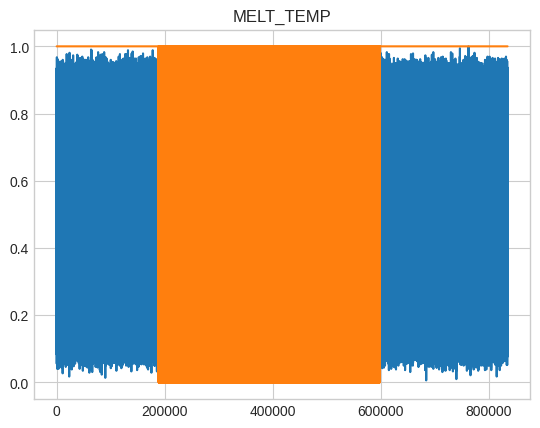

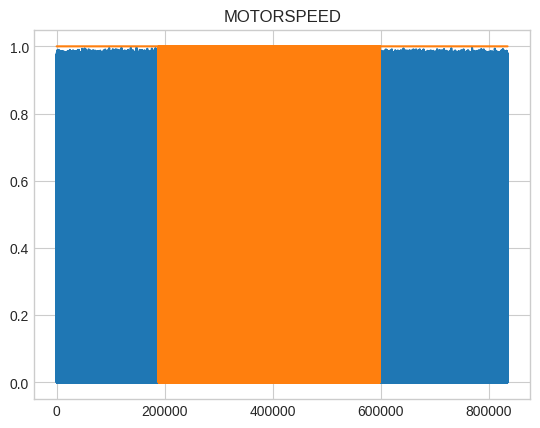

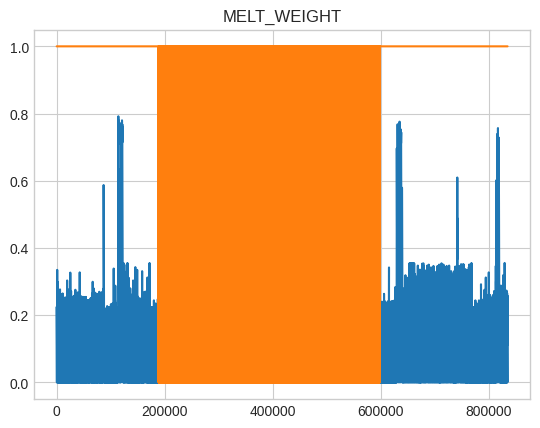

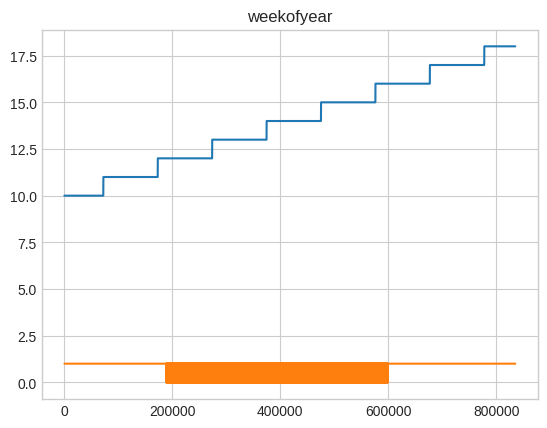

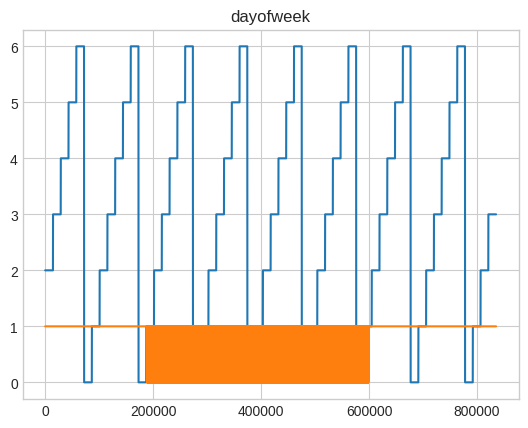

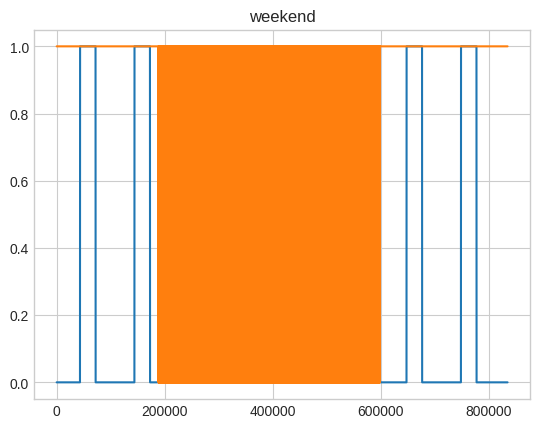

In [10]:
for col in X.columns:
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)
    x = np.linspace(0, X.shape[0])
    ax.plot(X[col])
    ax.plot(y['TAG'])

* 근무일과 같은 시간에 주기성을 띄기 보단 그냥 특정 시점에 집중적으로 불량이 몰려 있음.  
  따라서, 평일, 주 차 등의 근무 연관성은 낮다고 봐야 함.  
  (근무자가 불량이거나 투입 중량 시스템 오류 등 여러 원인 추정 가능)   

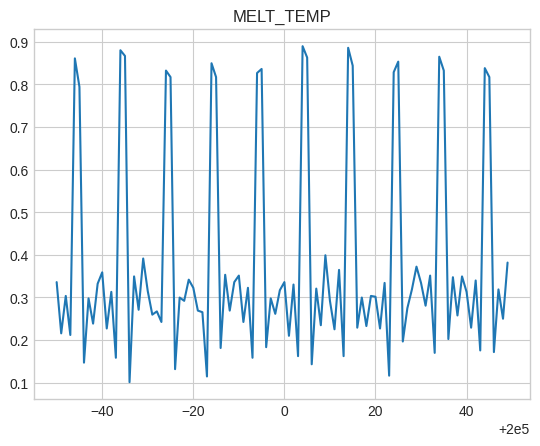

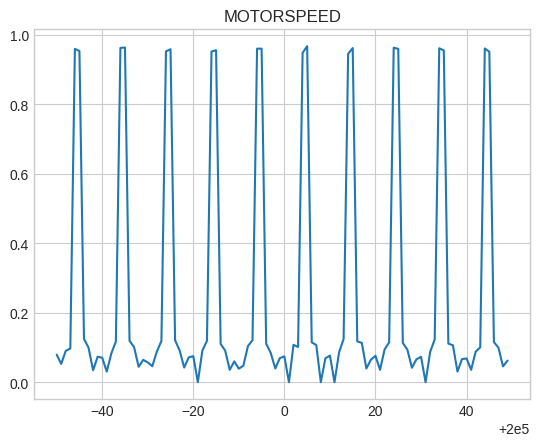

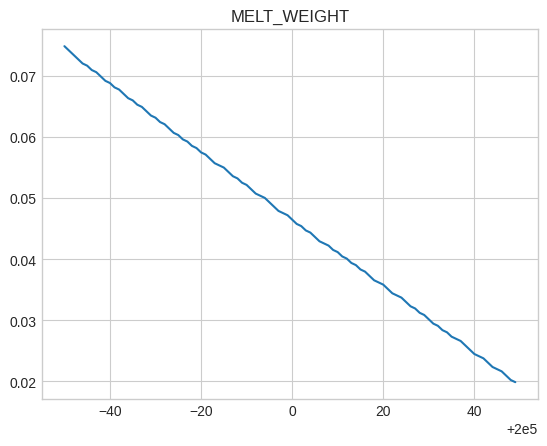

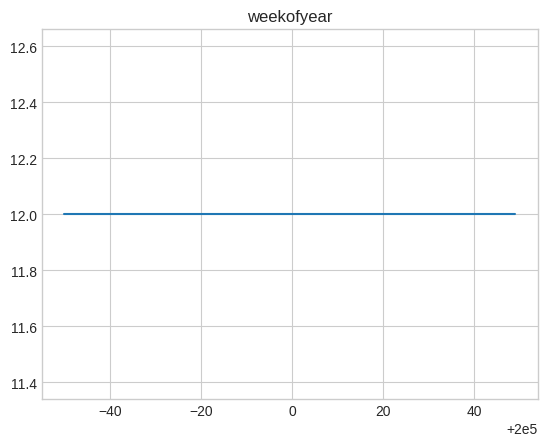

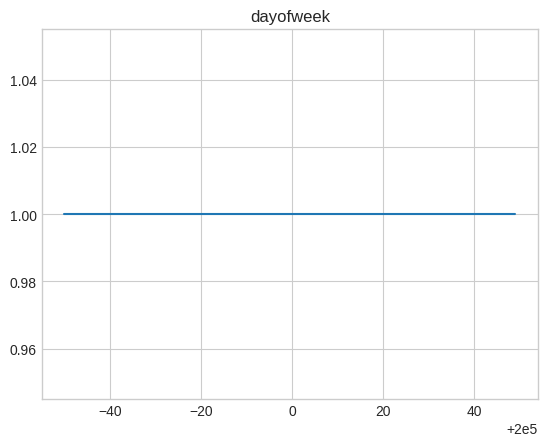

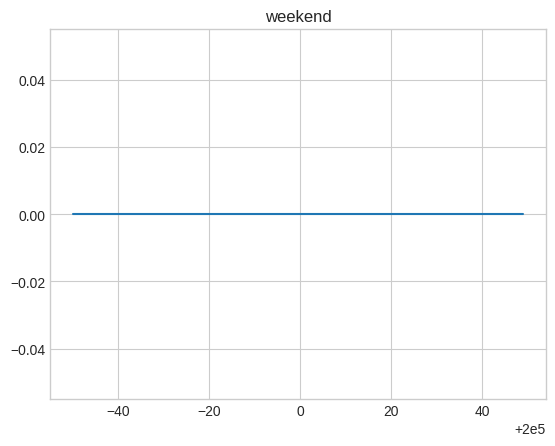

In [11]:
# 불량 발생 지점 확대, 그림이 잘 보이게 하기 위해 첫 번째는 라벨 없이 데이터만 도시 
eventrow = 200000

minx = eventrow - 50
maxx = eventrow + 50

for col in X.columns:
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)
    
    x = np.linspace(minx, maxx)
    ax.plot(X[col][minx : maxx])
#     ax.plot(y['TAG'][minx : maxx])

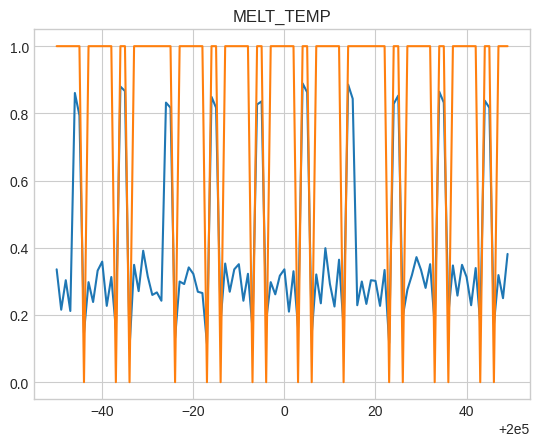

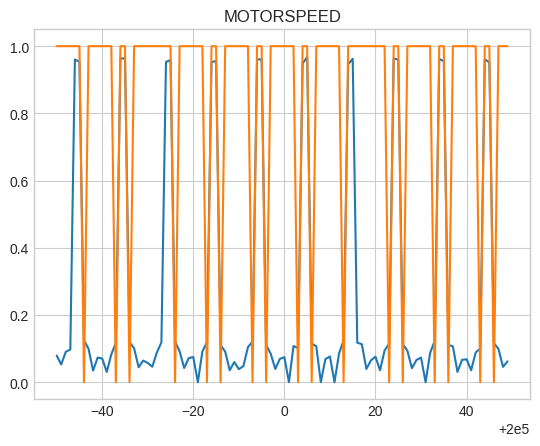

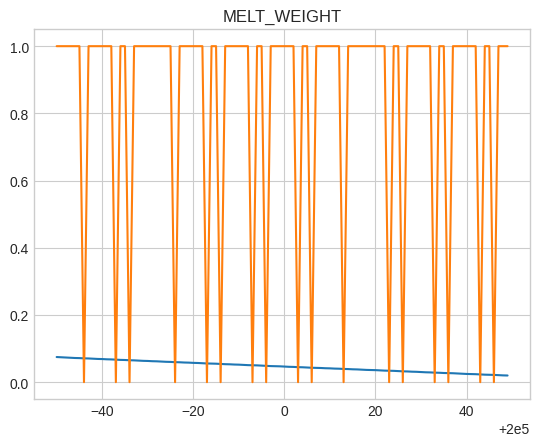

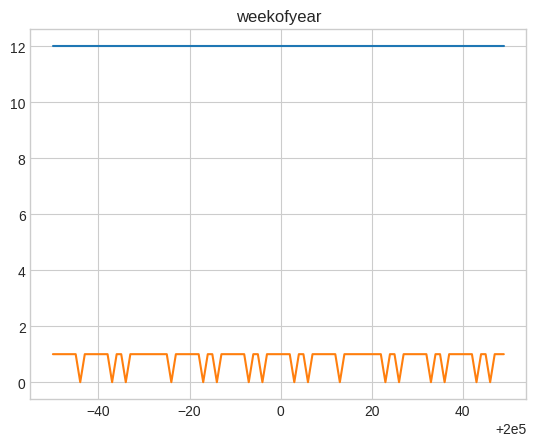

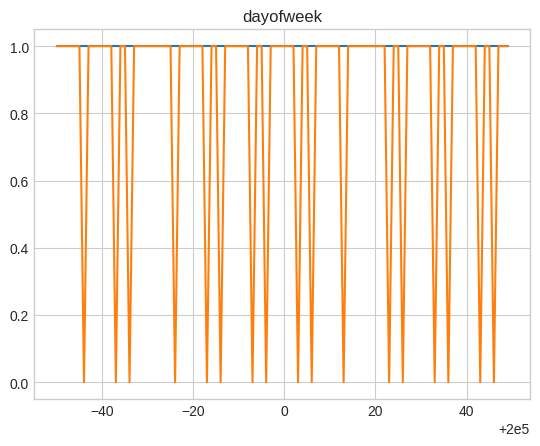

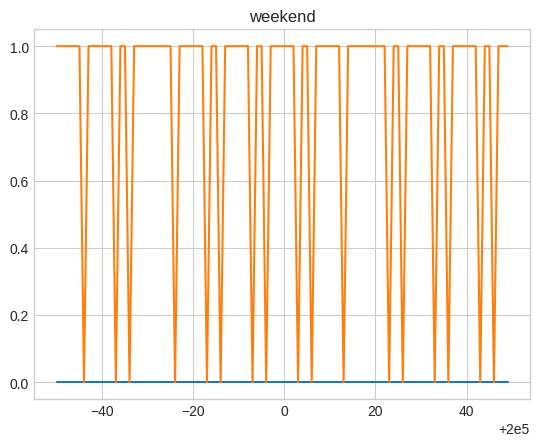

In [12]:
# 불량 발생 지점 확대, 라벨과 비교 : 시간적인 feature 들과 무관하며, 광범위한 특정 영역 대에서 집중 발생함을 알 수 있음. 
eventrow = 200000

minx = eventrow - 50
maxx = eventrow + 50

for col in X.columns:
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    plt.title(col)
    
    x = np.linspace(minx, maxx)
    ax.plot(X[col][minx : maxx])
    ax.plot(y['TAG'][minx : maxx])

In [13]:
X['TAG'] = y['TAG']

normal = X[X['TAG'] == 1]
anomaly = X[X['TAG'] == 0]

print(normal.shape)
print(anomaly.shape)

(658133, 7)
(177067, 7)


In [14]:
# 정상과 비 정상의 통계 정보 : 날짜 관련은 TAG 와 상관 없음을 알 수 있다. 
normal.describe()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,weekofyear,dayofweek,weekend,TAG
count,658133.000000,658133.000000,658133.000000,658133.000000,658133.000000,658133.000000,658133.0
mean,0.423409,0.303533,0.145226,14.045883,2.931464,0.263032,1.0
std,0.259646,0.384564,0.112751,2.663066,1.949122,0.440280,0.0
min,0.005725,0.000000,0.000000,10.000000,0.000000,0.000000,1.0
25%,0.257634,0.070953,0.064539,11.000000,1.000000,0.000000,1.0
50%,0.326336,0.095898,0.132979,14.000000,3.000000,0.000000,1.0
75%,0.774809,0.942905,0.202128,16.000000,5.000000,1.000000,1.0
max,1.000000,1.000000,1.000000,18.000000,6.000000,1.000000,1.0


In [15]:
anomaly.describe()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,weekofyear,dayofweek,weekend,TAG
count,177067.000000,177067.000000,177067.000000,177067.000000,177067.000000,177067.000000,177067.0
mean,0.237386,0.073988,0.153666,13.504159,3.173415,0.323550,0.0
std,0.069526,0.037595,0.111282,1.018455,2.032249,0.467832,0.0
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.0
25%,0.181298,0.040466,0.070922,13.000000,1.000000,0.000000,0.0
50%,0.248092,0.078160,0.145745,13.000000,3.000000,0.000000,0.0
75%,0.284351,0.109202,0.217730,14.000000,5.000000,1.000000,0.0
max,0.471374,0.149667,0.795745,16.000000,6.000000,1.000000,0.0


In [16]:
from plotly import graph_objs as go
from plotly.offline import iplot

In [17]:
# GIT 업로드 용량 문제로 주석 처리 : 온도 - 모터 속도 - 중량 순으로 연관도를 보임. 

# features = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT']

# for col in features:
#     trace0 = go.Box(
#                     y=normal[col],
#                     name="normal state",
#                     marker=dict(
#                     color = 'rgb(12, 12, 140)',
#                     )
#     )
    
#     trace1 = go.Box(
#                     y=anomaly[col],
#                     name="anomaly state",
#                     marker=dict(
#                     color = 'rgb(12, 128, 128)',
#                     )
#     )
#     data = [trace0, trace1]
#     iplot(data)